In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1 - Loading in the Data

In [5]:
#Import data using np.loadtxt
clean_data = np.loadtxt('wifi_db/clean_dataset.txt')
noisy_data = np.loadtxt('wifi_db/noisy_dataset.txt')

In [6]:
#Explore clean data
print(clean_data)
print('length:', len(clean_data))
print('size:', clean_data.size)
print('shape:', clean_data.shape)

[[-64. -56. -61. ... -82. -81.   1.]
 [-68. -57. -61. ... -85. -85.   1.]
 [-63. -60. -60. ... -85. -84.   1.]
 ...
 [-62. -59. -46. ... -87. -88.   4.]
 [-62. -58. -52. ... -90. -85.   4.]
 [-59. -50. -45. ... -88. -87.   4.]]
length: 2000
size: 16000
shape: (2000, 8)


In [7]:
#Explore noisy data
print(noisy_data)
print('length:', len(noisy_data))
print('size:', noisy_data.size)
print('shape:', noisy_data.shape)

[[-59. -53. -51. ... -79. -87.   4.]
 [-66. -53. -59. ... -81. -79.   1.]
 [-41. -57. -63. ... -66. -65.   2.]
 ...
 [-57. -54. -56. ... -79. -82.   1.]
 [-56. -52. -50. ... -85. -88.   3.]
 [-46. -54. -47. ... -80. -73.   3.]]
length: 2000
size: 16000
shape: (2000, 8)


# Step 2 - Creating Decision trees

## Testing Entropy

In [8]:
#Function to calculate information entropy - H(x)
def entropy(dataset):
    labels = dataset[:, -1] #last column of dataset
    classes, counts = np.unique(labels, return_counts=True) #sorts y, and count number of each item in y
    probabilities = counts / counts.sum() #probability of each class
    return -np.sum(probabilities * np.log2(probabilities)) #entropy formula

In [9]:
print('Testing entropy for clean data')
clean_entropy = entropy(clean_data) #H(x)
print('Entropy of clean data:', clean_entropy, '\n')

print('Testing entropy for noisy data')
noisy_entropy = entropy(noisy_data) #H(x)
print('Entropy of noisy data:', noisy_entropy)

Testing entropy for clean data
Entropy of clean data: 2.0 

Testing entropy for noisy data
Entropy of noisy data: 1.9997572810101025


## Testing Information Gain

In [10]:
# Function to calculate information gain -IG
def information_gain(dataset, split_attribute, split_value):
    # Split the dataset based on the given split attribute and split value
    left_split = dataset[dataset[:, split_attribute] <= split_value]
    right_split = dataset[dataset[:, split_attribute] > split_value]
    
    # Compute the probabilities of each split
    p_left = len(left_split) / len(dataset)
    p_right = len(right_split) / len(dataset)
    
    # Calculate entropy for the full dataset and each split subset
    gain = entropy(dataset) - (p_left * entropy(left_split) + p_right * entropy(right_split))
    return gain

In [11]:
## Test information gain
print('Testing information gain for clean data')
clean_ig = information_gain(clean_data, 0, -60)
print('Information gain of clean data:', clean_ig, '\n')

print('Testing information gain for noisy data')
noisy_ig = information_gain(noisy_data, 0, -60)
print('Information gain of noisy data:', noisy_ig)

Testing information gain for clean data
Information gain of clean data: 0.48211795091719223 

Testing information gain for noisy data
Information gain of noisy data: 0.3508692084516851


## Test Find Split

#### Version 1 (slower)

In [12]:
def find_split(dataset):
    # Initialize variables to track the best split
    best_gain = 0
    best_attribute = None
    best_split_value = None

    # Iterate over each attribute (exclude the last column, which is the label)
    for attribute in range(dataset.shape[1] - 1):
        # Sort the dataset based on the current attribute
        sorted_data = dataset[dataset[:, attribute].argsort()]
        
        # Find unique values in the attribute to create potential split points
        attribute_values = sorted_data[:, attribute]
        
        # Loop through midpoints between consecutive values to find potential split values
        for i in range(1, len(attribute_values)):
            # Calculate midpoint between consecutive unique values as the potential split point
            split_value = (attribute_values[i - 1] + attribute_values[i]) / 2

            # Calculate the information gain for this split
            gain = information_gain(dataset, attribute, split_value)
            
            # Update if we found a better split
            if gain > best_gain:
                best_gain = gain
                best_attribute = attribute
                best_split_value = split_value

    return best_attribute, best_split_value, best_gain

# Example usage (assuming 'clean_data' is your dataset)
print(find_split(clean_data))

(0, -55.0, 0.9380693889198293)


### Version 2 (fastest)

In [13]:
def find_split(data):
    n_samples, n_features = data.shape
    best_gain = -float('inf')
    best_feature = None
    best_split = None

    # Iterate over each feature (exclude the last column which is labels)
    for feature in range(n_features - 1):
        # Sort data based on current feature
        sorted_indices = data[:, feature].argsort()
        sorted_data = data[sorted_indices]

        # Loop over possible split points (between consecutive unique values)
        for i in range(1, n_samples):
            if sorted_data[i, feature] != sorted_data[i - 1, feature]:
                # Midpoint between consecutive values as a potential split
                split_value = (sorted_data[i - 1, feature] + sorted_data[i, feature]) / 2

                # Calculate the information gain for the split
                gain = information_gain(data, feature, split_value)

                # Update the best split if this gain is higher
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_split = split_value

    return best_feature, best_split, best_gain

# Example usage (assuming 'clean_data' is your dataset)
print(find_split(clean_data))

(0, -54.5, 0.9380693889198293)


## Test Decision Tree

### version1, with more keys per nodes

In [14]:
def decision_tree_learning1(data, depth=0):
    # Base case: If all samples have the same label, return a leaf node
    labels = data[:, -1]  # Last column is assumed to be labels
    if len(np.unique(labels)) == 1:
        # All labels are the same, create a leaf node
        return {'leaf': True, 'label': labels[0], 'depth': depth}

    # Recursive case: Find the best split
    best_feature, best_split, best_gain = find_split(data)
    
    # If no gain, return a leaf node with the most common label
    if best_gain == 0:
        most_common_label = np.bincount(labels.astype(int)).argmax()
        return {'leaf': True, 'label': most_common_label, 'depth': depth}
    
    # Partition data into left and right based on the best split
    left_data = data[data[:, best_feature] <= best_split]
    right_data = data[data[:, best_feature] > best_split]
    
    # Create the current decision node
    node = {
        'leaf': False,
        'attribute': best_feature,
        'value': best_split,
        'left': decision_tree_learning1(left_data, depth + 1),
        'right': decision_tree_learning1(right_data, depth + 1),
        'depth': depth
    }
    
    return node

### version 2, less keys per nodes

In [15]:
def decision_tree_learning2(dataset, depth=0):
    labels = dataset[:, -1]  # Last column is the label
    
    # Base case: if all labels are the same, return a leaf node
    if len(np.unique(labels)) == 1:
        return {'label': labels[0], 'depth': depth}
    
    # Otherwise, find the best split
    attribute, value, gain = find_split(dataset) 
    if attribute is None:
        # If no split is possible, return a leaf with the majority label
        unique, counts = np.unique(labels, return_counts=True)
        majority_label = unique[np.argmax(counts)]
        return {'label': majority_label, 'depth': depth}
    
    # Split the dataset
    left_split = dataset[dataset[:, attribute] <= value]
    right_split = dataset[dataset[:, attribute] > value]
    
    # Create a new decision node
    tree = {
        'attribute': attribute,
        'value': value,
        'depth': depth,
        'left': decision_tree_learning2(left_split, depth + 1),
        'right': decision_tree_learning2(right_split, depth + 1)
    }
    
    return tree

In [16]:
# Example usage (assuming 'clean_data' is your dataset)
tree1 = decision_tree_learning1(clean_data)
print("Tree 1")
print(tree1, '\n')


# Example usage (assuming 'clean_data' is your dataset)
tree2 = decision_tree_learning2(clean_data)
print("Tree 2")
print(tree2, '\n')

print("Tree 1 keys")
print(tree1.keys(), '\n')

print("Tree 2 keys")
print(tree2.keys()) 

Tree 1
{'leaf': False, 'attribute': 0, 'value': -54.5, 'left': {'leaf': False, 'attribute': 4, 'value': -59.5, 'left': {'leaf': False, 'attribute': 3, 'value': -55.5, 'left': {'leaf': False, 'attribute': 2, 'value': -55.5, 'left': {'leaf': True, 'label': 1.0, 'depth': 4}, 'right': {'leaf': False, 'attribute': 6, 'value': -85.5, 'left': {'leaf': False, 'attribute': 4, 'value': -62.5, 'left': {'leaf': False, 'attribute': 5, 'value': -85.5, 'left': {'leaf': False, 'attribute': 0, 'value': -58.0, 'left': {'leaf': True, 'label': 4.0, 'depth': 8}, 'right': {'leaf': True, 'label': 3.0, 'depth': 8}, 'depth': 7}, 'right': {'leaf': True, 'label': 1.0, 'depth': 7}, 'depth': 6}, 'right': {'leaf': True, 'label': 4.0, 'depth': 6}, 'depth': 5}, 'right': {'leaf': True, 'label': 1.0, 'depth': 5}, 'depth': 4}, 'depth': 3}, 'right': {'leaf': False, 'attribute': 1, 'value': -50.5, 'left': {'leaf': True, 'label': 3.0, 'depth': 4}, 'right': {'leaf': False, 'attribute': 0, 'value': -59.0, 'left': {'leaf': Tr

In [17]:
# Example usage (assuming 'noisy_data' is your dataset)
tree1 = decision_tree_learning1(noisy_data)
print("Tree 1")
print(tree1, '\n')


# Example usage (assuming 'noisy_data' is your dataset)
tree2 = decision_tree_learning2(noisy_data)
print("Tree 2")
print(tree2, '\n')

print("Tree 1 keys")
print(tree1.keys(), '\n')

print("Tree 2 keys")
print(tree2.keys()) 

Tree 1
{'leaf': False, 'attribute': 0, 'value': -54.5, 'left': {'leaf': False, 'attribute': 4, 'value': -59.5, 'left': {'leaf': False, 'attribute': 3, 'value': -55.5, 'left': {'leaf': False, 'attribute': 2, 'value': -55.5, 'left': {'leaf': False, 'attribute': 6, 'value': -81.5, 'left': {'leaf': False, 'attribute': 6, 'value': -86.5, 'left': {'leaf': False, 'attribute': 2, 'value': -61.5, 'left': {'leaf': False, 'attribute': 4, 'value': -65.5, 'left': {'leaf': False, 'attribute': 4, 'value': -82.5, 'left': {'leaf': False, 'attribute': 0, 'value': -67.0, 'left': {'leaf': True, 'label': 3.0, 'depth': 10}, 'right': {'leaf': True, 'label': 1.0, 'depth': 10}, 'depth': 9}, 'right': {'leaf': False, 'attribute': 4, 'value': -76.5, 'left': {'leaf': True, 'label': 1.0, 'depth': 10}, 'right': {'leaf': False, 'attribute': 0, 'value': -72.5, 'left': {'leaf': True, 'label': 4.0, 'depth': 11}, 'right': {'leaf': False, 'attribute': 2, 'value': -64.5, 'left': {'leaf': False, 'attribute': 3, 'value': -65

## Test Plot Tree

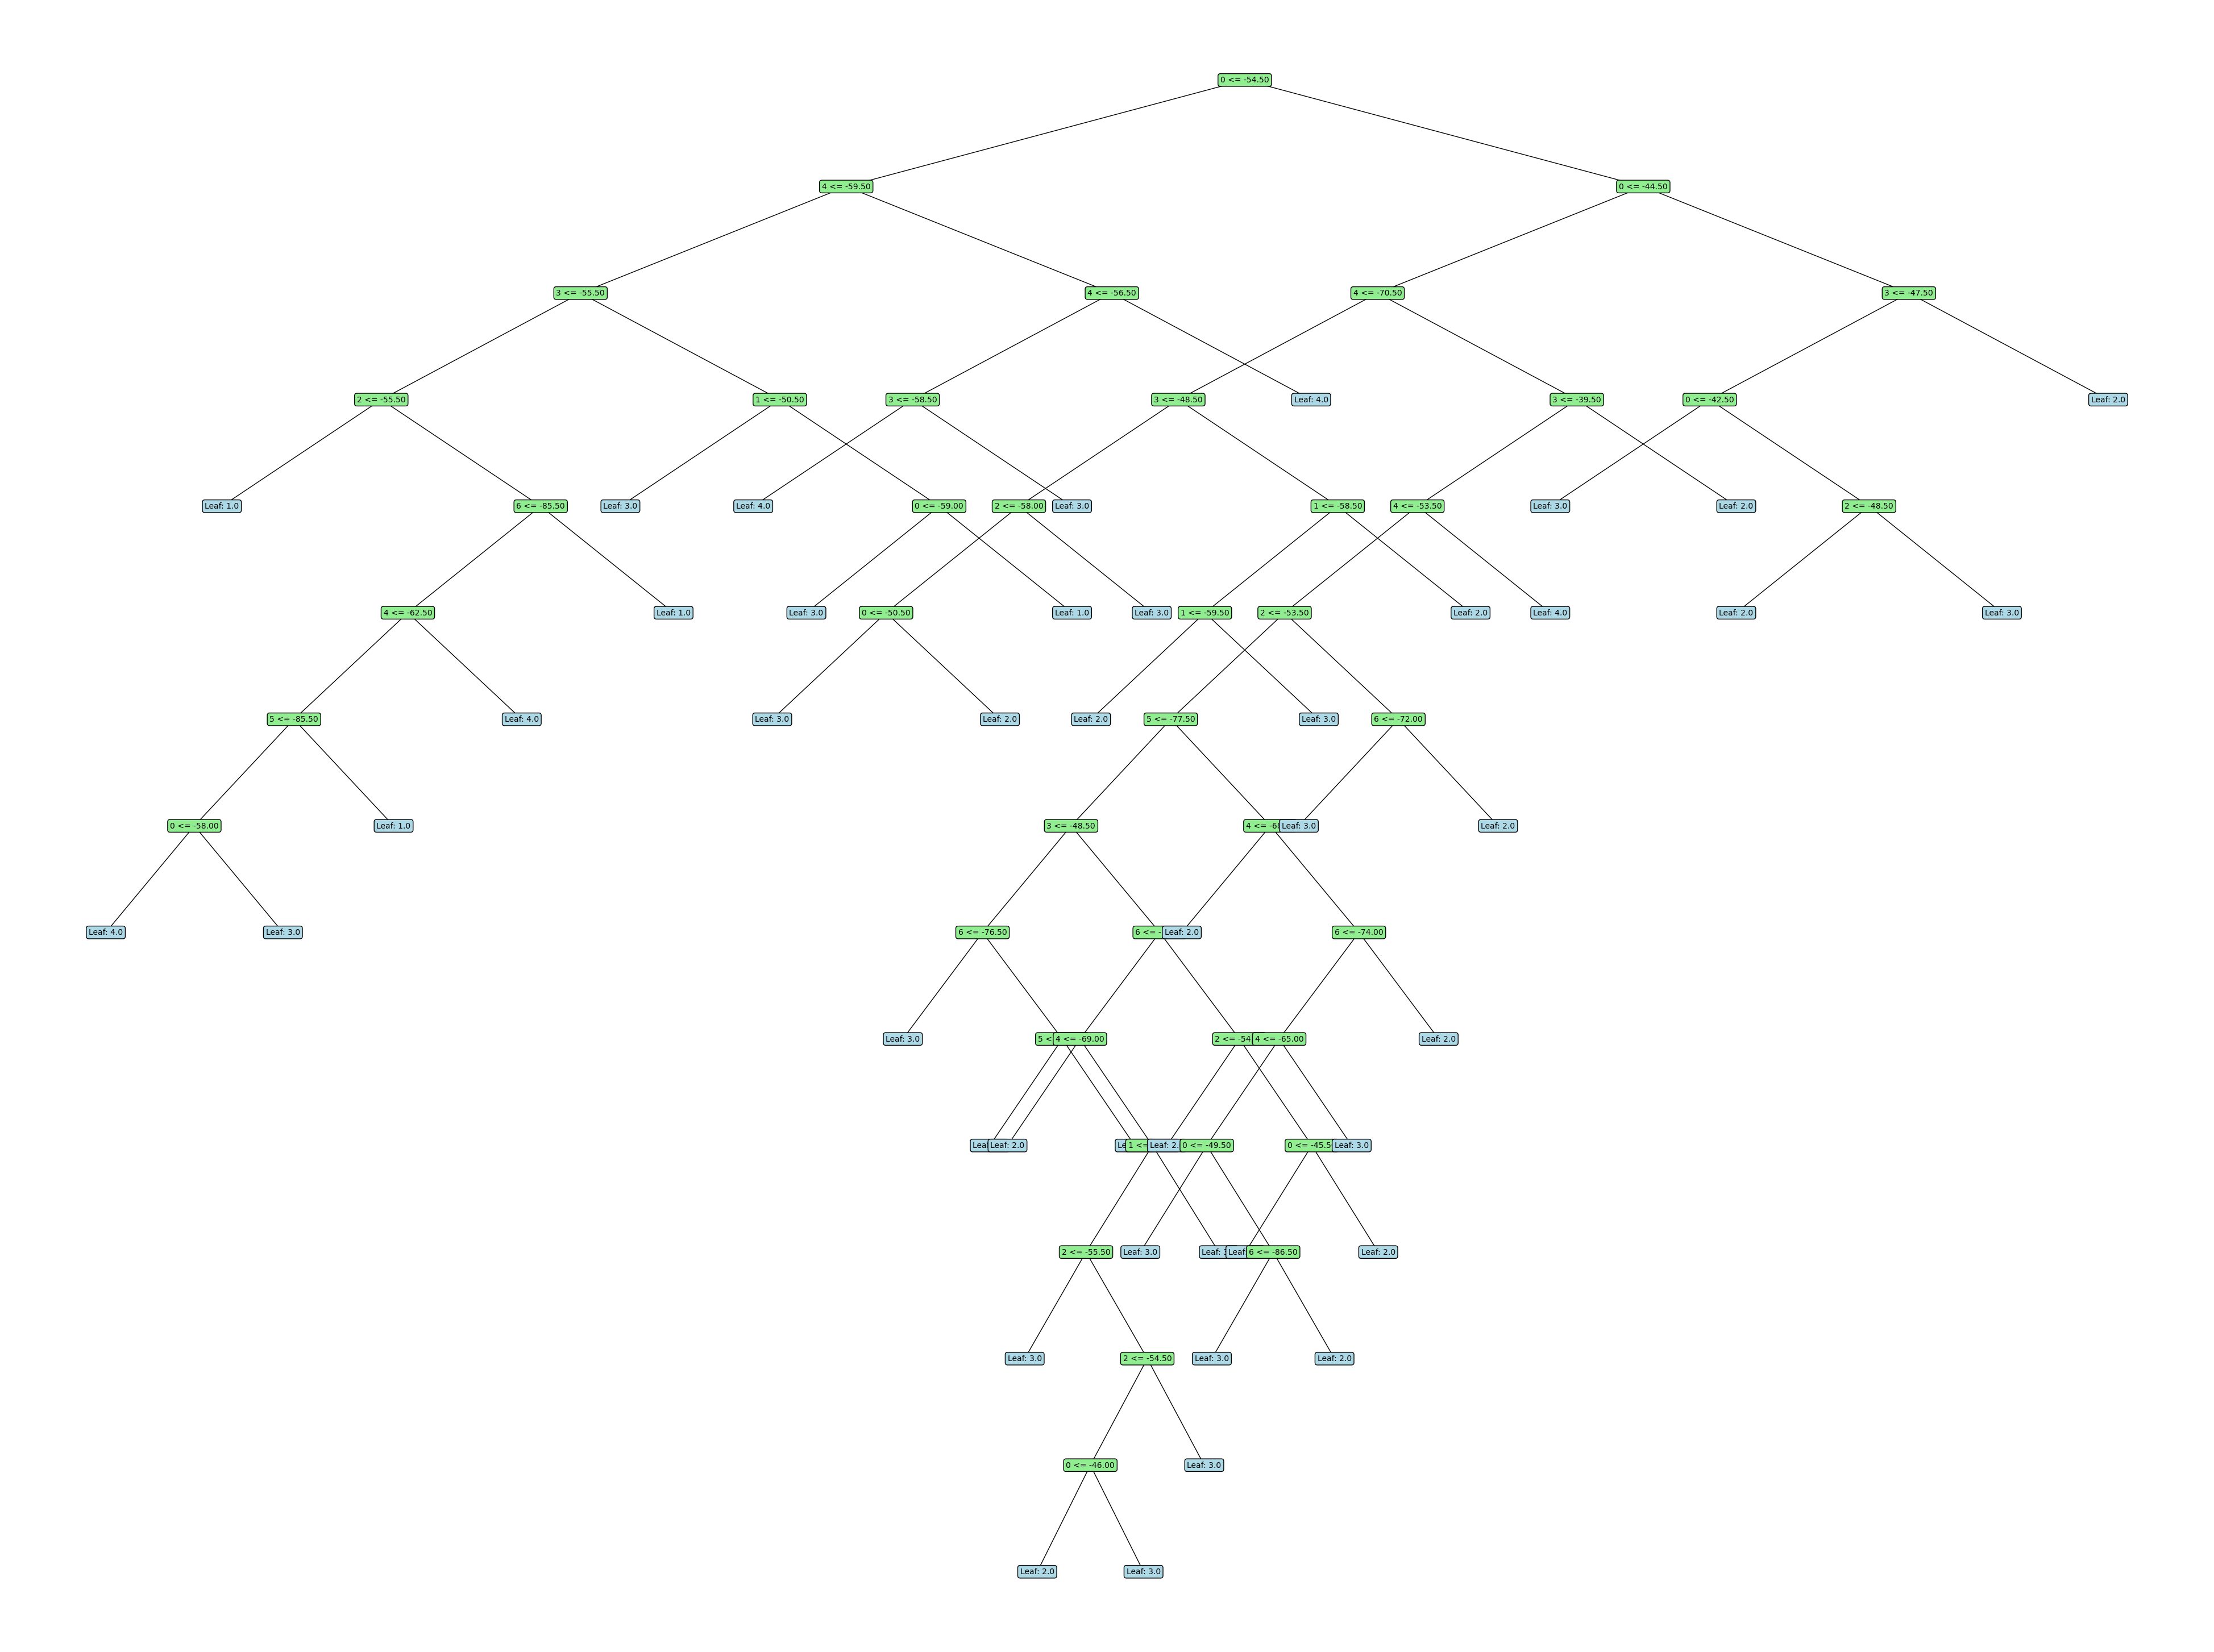

In [18]:
def plot_tree(node, x=0.5, y=1, level=1, spacing=0.3, ax=None, width_multiplier=50, height_multiplier=2.5):
    """
    Recursively plots the decision tree with improved spacing.
    :param node: Dictionary containing tree structure
    :param x: X-coordinate of the current node
    :param y: Y-coordinate of the current node
    :param level: Depth level of the node in the tree
    :param spacing: Horizontal spacing for child nodes
    :param ax: Matplotlib Axes object
    :param width_multiplier: Controls horizontal scaling of the plot
    :param height_multiplier: Controls vertical scaling of the plot
    """
    if ax is None:
        max_depth = get_tree_depth(node)  # Calculate the depth of the tree
        fig, ax = plt.subplots(figsize=(width_multiplier, height_multiplier * max_depth))
        ax.axis("off")

    # Check if the node is a leaf
    if node["leaf"]:
        ax.text(x, y, f"Leaf: {node['label']}", 
                ha="center", va="center", bbox=dict(boxstyle="round,pad=0.3", 
                                                    edgecolor="black", facecolor="lightblue"))
    else:
        # Plot current node with split info
        ax.text(x, y, f"{node['attribute']} <= {node['value']:.2f}",
                ha="center", va="center", bbox=dict(boxstyle="round,pad=0.3", 
                                                    edgecolor="black", facecolor="lightgreen"))
        
        # Adjust horizontal spacing based on the level
        adjusted_spacing = spacing / (level + 1)
        
        # Calculate child node positions
        left_x = x - adjusted_spacing
        right_x = x + adjusted_spacing
        child_y = y - 0.15
        
        # Draw the branches
        ax.plot([x, left_x], [y, child_y], "k-", lw=1)
        ax.plot([x, right_x], [y, child_y], "k-", lw=1)
        
        # Recursively plot left and right children
        plot_tree(node["left"], x=left_x, y=child_y, level=level + 1, spacing=spacing, ax=ax, 
                  width_multiplier=width_multiplier, height_multiplier=height_multiplier)
        plot_tree(node["right"], x=right_x, y=child_y, level=level + 1, spacing=spacing, ax=ax, 
                  width_multiplier=width_multiplier, height_multiplier=height_multiplier)

    # Display plot only at the root level
    if ax is None:
        plt.show()

def get_tree_depth(node):
    """
    Recursively calculate the depth of the tree.
    :param node: Dictionary containing tree structure
    :return: Integer representing the depth of the tree
    """
    if node["leaf"]:
        return 1
    left_depth = get_tree_depth(node["left"])
    right_depth = get_tree_depth(node["right"])
    return 1 + max(left_depth, right_depth)

# Example usage with the generated decision tree
# Assuming 'tree' is the tree generated by `decision_tree_learning1`
tree = decision_tree_learning1(clean_data)
plot_tree(tree)

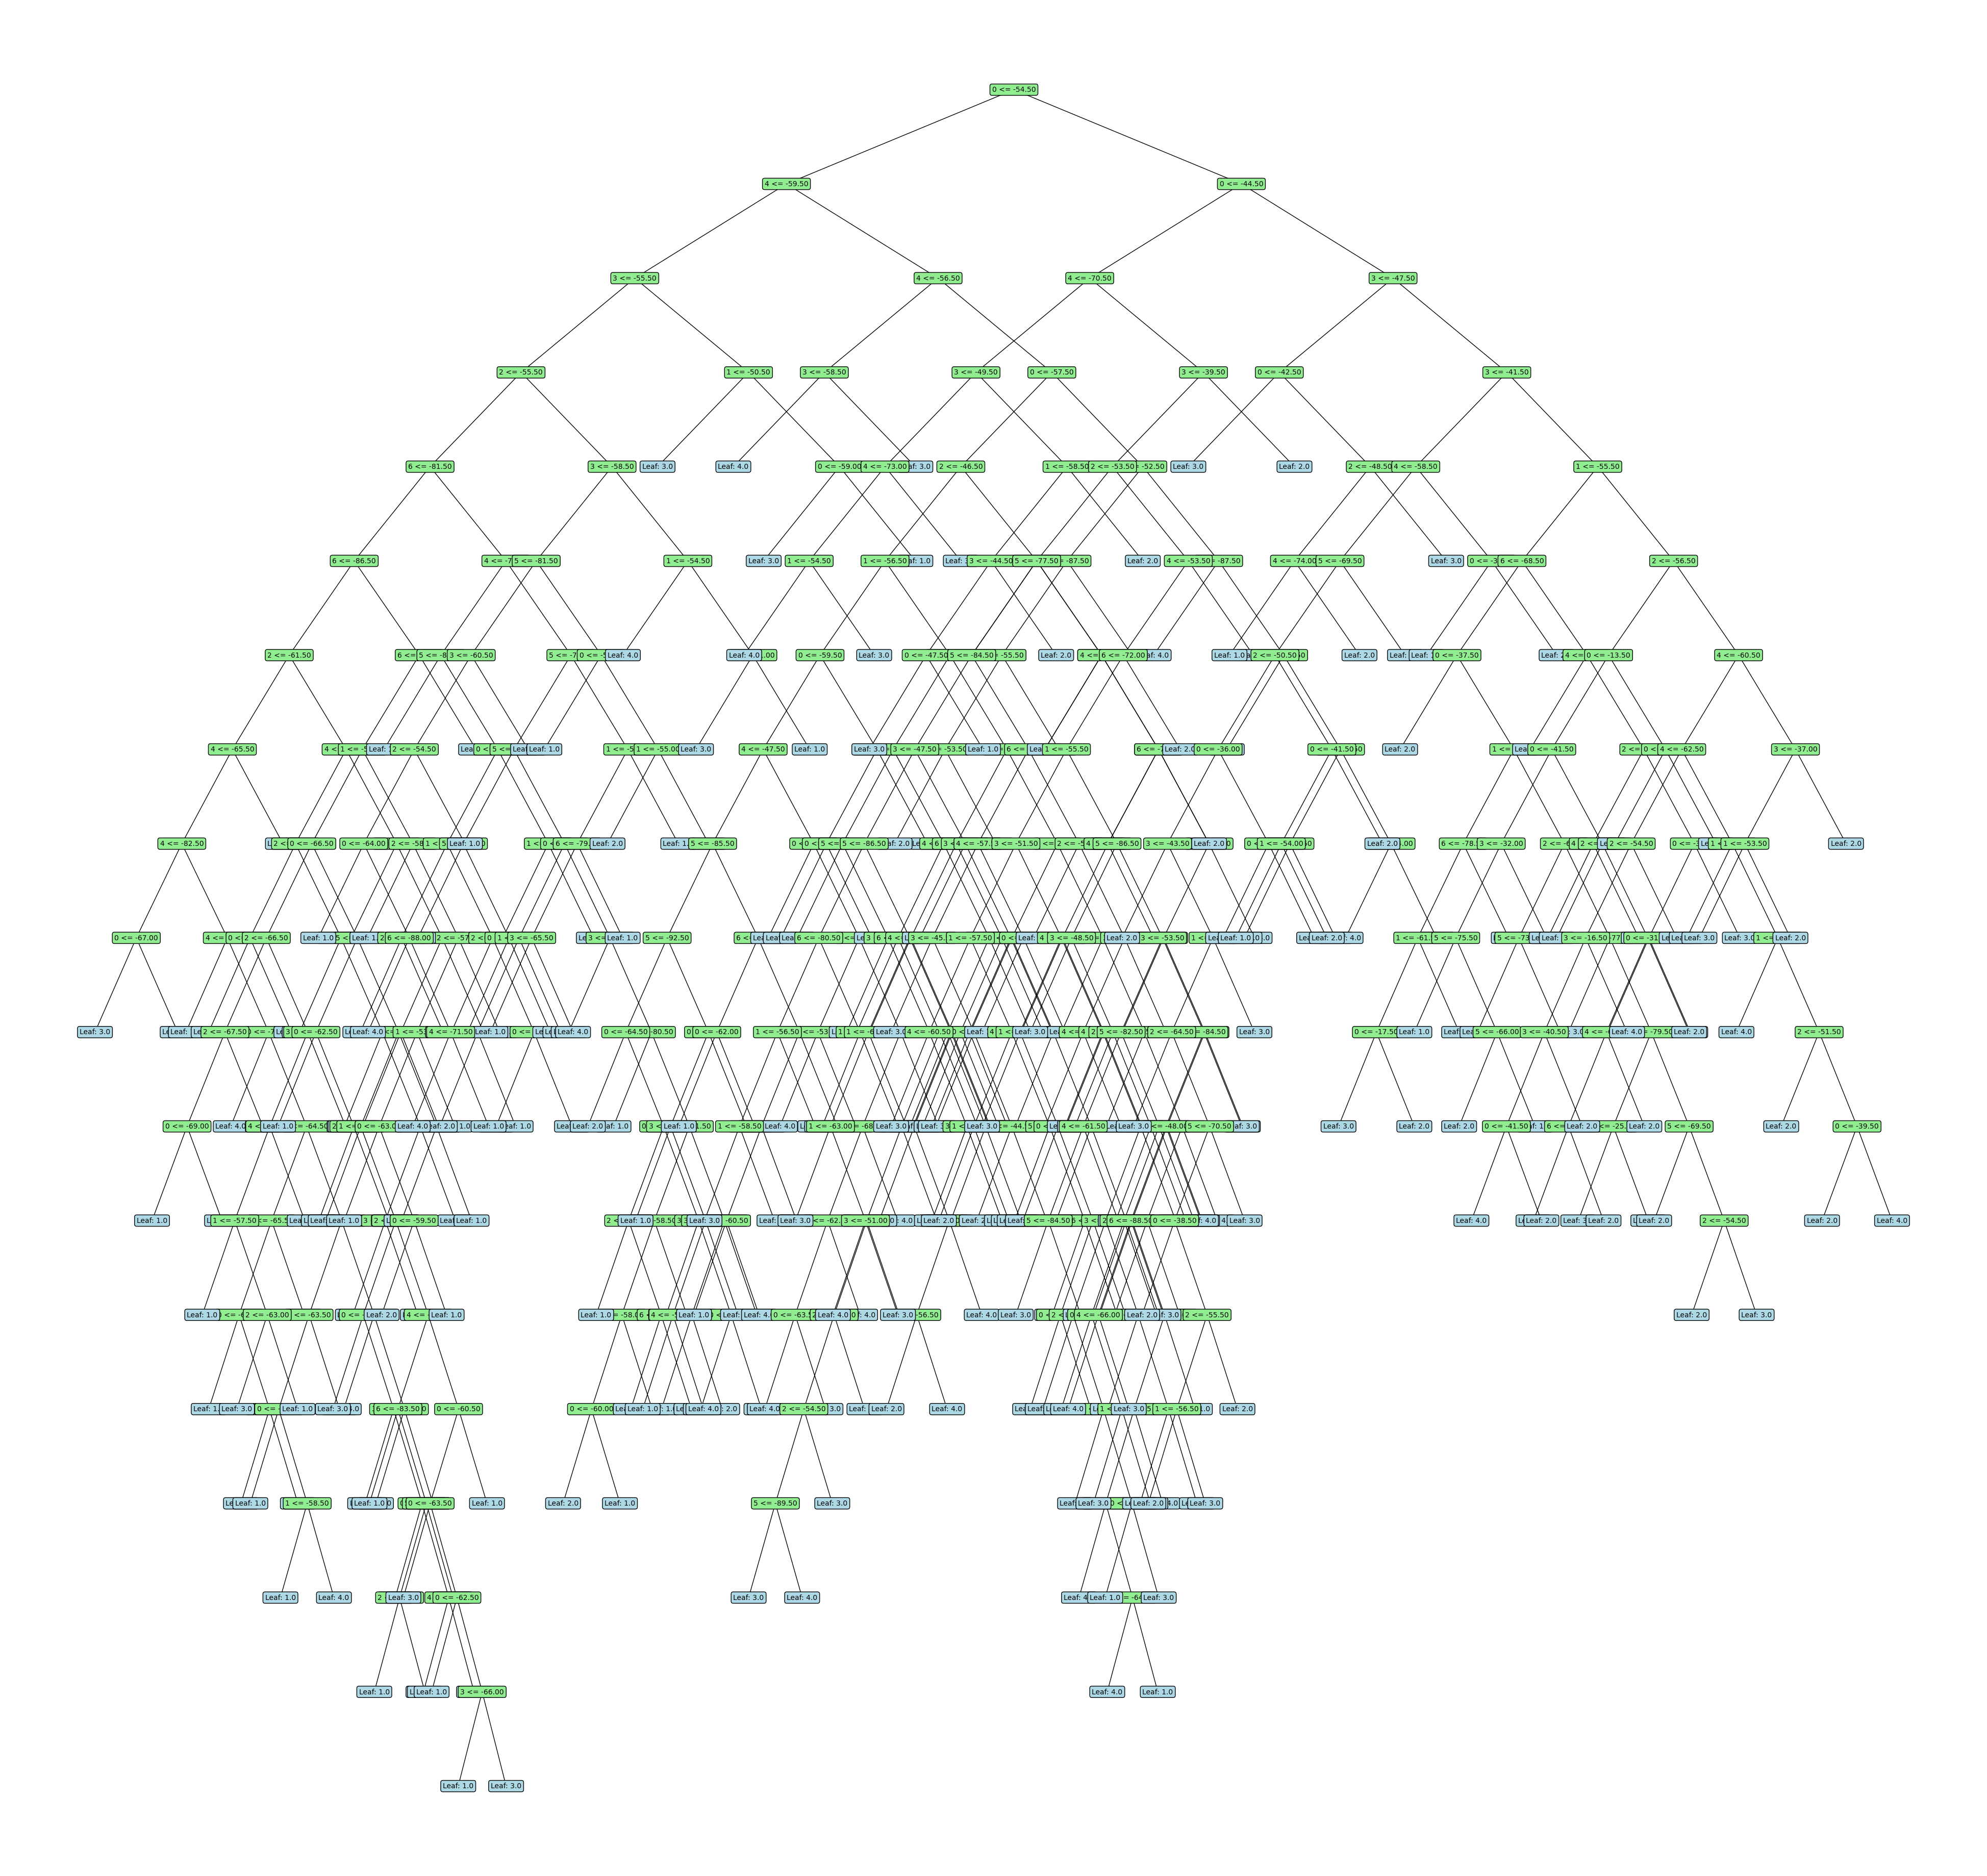

In [19]:
# Example usage with the generated decision tree
# Assuming 'tree' is the tree generated by `decision_tree_learning1`
tree = decision_tree_learning1(noisy_data)
plot_tree(tree)

## Step 3: Evaluation

In [20]:
def k_fold_split(data, n_folds=10, seed=None):
    """Splits the data into k folds with an optional random seed."""
    indices = np.arange(len(data))
    
    if seed is not None:
        np.random.seed(seed)  # Set the random seed for reproducibility
    
    np.random.shuffle(indices)
    folds = np.array_split(indices, n_folds)
    return folds

def cross_validate_and_evaluate(data, n_folds=10, seed=None):
    folds = k_fold_split(data, n_folds, seed)
    all_predictions = []
    all_true_labels = []

    for i in range(n_folds):
        # Prepare training and testing sets
        test_indices = folds[i]
        train_indices = np.concatenate(folds[:i] + folds[i+1:])  # All other folds
        train_data, test_data = data[train_indices], data[test_indices]
        
        # Train the decision tree
        tree = decision_tree_learning1(train_data)  # Your decision tree training function
        
        # Get true labels from the test data
        true_labels = test_data[:, -1]  # Assuming the last column is the label
        predictions = classify(test_data, tree)  # Your classification function
        
        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)

    return np.array(all_true_labels), np.array(all_predictions)


def predict(row, tree):
    """
    Predict the class label for a single data instance using the decision tree.
    
    :param row: The data instance to classify (as a numpy array)
    :param tree: The decision tree (as a dictionary)
    :return: The predicted class label
    """
    if tree['leaf']:  # Check if it's a leaf node
        return tree['label']  # Return the label at the leaf node
    
    # Get the attribute and value for the current node
    attribute = tree['attribute']
    value = tree['value']
    
    # Decide which branch to follow based on the row's attribute value
    if row[attribute] <= value:
        return predict(row, tree['left'])  # Go left
    else:
        return predict(row, tree['right'])  # Go right

def classify(data, tree):
    """Classify the data using the trained decision tree."""
    predictions = []
    for row in data:
        predictions.append(predict(row, tree))  # Implement the predict function based on your tree structure
    return predictions

In [21]:
def confusion_matrix(true_labels, predictions, num_classes):
    """Compute confusion matrix as a 2D numpy array."""

    # Convert the labels and predictions to numpy arrays into integers
    true_labels = np.array(true_labels, dtype=int)
    predictions = np.array(predictions, dtype=int)
    num_classes = int(num_classes)

    # Create the confusion matrix
    matrix = np.zeros((num_classes, num_classes), dtype=int)

    # Check if the true and predicted values are in the valid range
    for true, pred in zip(true_labels, predictions):
        if true < 1 or true > num_classes or pred < 1 or pred > num_classes:
            raise ValueError(f"Label or prediction out of bounds: true={true}, pred={pred}")
        
        # Subtract 1 from each value to get the 0-based index since the preds and true 
        # are from 1-4 and we need 0-3 for matrix index
        matrix[true-1, pred-1] += 1

    return matrix

def calculate_metrics(conf_matrix):
    """Calculate accuracy, precision, recall, and F1-score from confusion matrix."""
    num_classes = conf_matrix.shape[0]
    accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
    
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)

    for i in range(num_classes):
        precision[i] = conf_matrix[i, i] / np.sum(conf_matrix[:, i]) if np.sum(conf_matrix[:, i]) > 0 else 0
        recall[i] = conf_matrix[i, i] / np.sum(conf_matrix[i, :]) if np.sum(conf_matrix[i, :]) > 0 else 0
        f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0
    
    return accuracy, precision, recall, f1

In [22]:
# Example usage with a specific seed
seed = 42  # Choose your seed for reproducibility

# Assuming true_labels_clean and predictions_clean are already obtained
true_labels_clean, predictions_clean = cross_validate_and_evaluate(clean_data, seed=seed)
num_classes = np.max(np.unique(true_labels_clean))  # This should be 4

# Create confusion matrix
conf_matrix_clean = confusion_matrix(true_labels_clean, predictions_clean, num_classes)
accuracy_clean, precision_clean, recall_clean, f1_clean = calculate_metrics(conf_matrix_clean)

# Output results
print("Clean Data Evaluation:")
print("Confusion Matrix:\n", conf_matrix_clean)
print("Accuracy:", accuracy_clean)
print("Precision:", precision_clean)
print("Recall:", recall_clean)
print("F1-Score:", f1_clean)

true_labels_noisy, predictions_noisy = cross_validate_and_evaluate(noisy_data, seed=seed)
conf_matrix_noisy = confusion_matrix(true_labels_noisy, predictions_noisy, num_classes)
accuracy_noisy, precision_noisy, recall_noisy, f1_noisy = calculate_metrics(conf_matrix_noisy)


print("\nNoisy Data Evaluation:")
print("Confusion Matrix:\n", conf_matrix_noisy)
print("Accuracy:", accuracy_noisy)
print("Precision:", precision_noisy)
print("Recall:", recall_noisy)
print("F1-Score:", f1_noisy)

Clean Data Evaluation:
Confusion Matrix:
 [[493   0   5   2]
 [  0 484  16   0]
 [  3  17 478   2]
 [  5   0   1 494]]
Accuracy: 0.9745
Precision: [0.98403194 0.96606786 0.956      0.99196787]
Recall: [0.986 0.968 0.956 0.988]
F1-Score: [0.98501499 0.96703297 0.956      0.98997996]

Noisy Data Evaluation:
Confusion Matrix:
 [[387  26  36  41]
 [ 32 398  36  31]
 [ 24  40 420  31]
 [ 48  27  31 392]]
Accuracy: 0.7985
Precision: [0.78818737 0.81059063 0.80305927 0.79191919]
Recall: [0.78979592 0.80080483 0.81553398 0.78714859]
F1-Score: [0.78899083 0.80566802 0.80924855 0.78952669]


### Plot confusion Matrix

In [23]:
def plot_confusion_matrix(matrix, title='Confusion Matrix'):
    """Plot a confusion matrix as a heatmap."""
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(matrix.shape[0])
    plt.xticks(tick_marks, np.arange(1, matrix.shape[0] + 1))  # Classes start from 1
    plt.yticks(tick_marks, np.arange(1, matrix.shape[0] + 1))
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Add text annotations
    thresh = matrix.max() / 2.  # Threshold for color
    for i, j in np.ndindex(matrix.shape):
        plt.text(j, i, format(matrix[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if matrix[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.show()

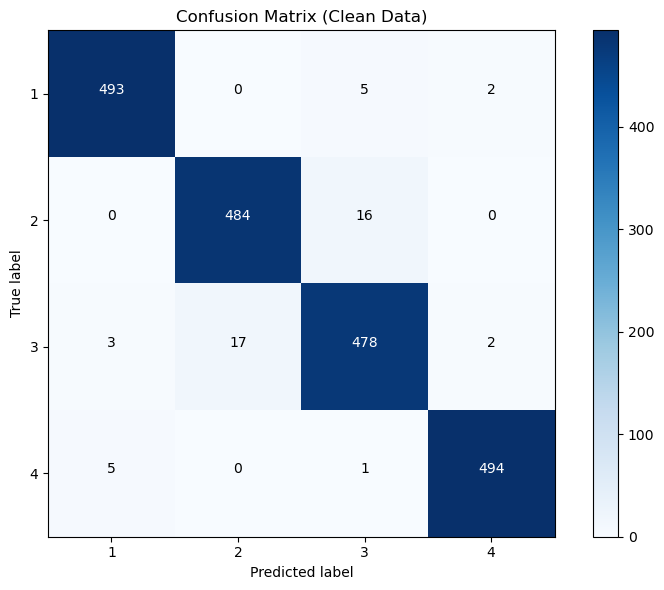

In [24]:
# Plot the clean data confusion matrix
plot_confusion_matrix(conf_matrix_clean, title='Confusion Matrix (Clean Data)')

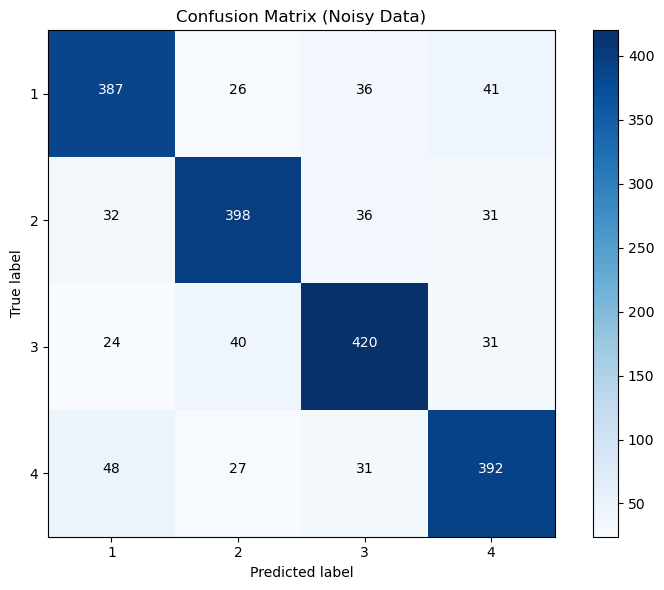

In [37]:
# Plot the noisy data confusion matrix
plot_confusion_matrix(conf_matrix_noisy, title='Confusion Matrix (Noisy Data)')

## Step 4: Pruning

In [109]:
def prune_tree(node, validation_data):
    """Recursively prune the decision tree."""
    # Base case: If the node is a leaf, return it as is
    if node.get('leaf', False):
        return node
    
    # Recursively prune left and right subtrees if they exist
    if 'left' in node:
        node['left'] = prune_tree(node['left'], validation_data)
    if 'right' in node:
        node['right'] = prune_tree(node['right'], validation_data)
    
    # Calculate error without pruning
    error_without_pruning = compute_validation_error(validation_data, node)
    
    # Create a leaf node with most common class
    predictions = classify(validation_data, node)
    # Convert predictions list to numpy array before using astype
    predictions = np.array(predictions)
    most_common_label = np.bincount(predictions.astype(int)).argmax()
    leaf_node = {'leaf': True, 'label': most_common_label}
    
    # Calculate error with pruning
    error_with_pruning = compute_validation_error(validation_data, leaf_node)
    
    # If pruning improves or maintains accuracy, return leaf node
    if error_with_pruning <= error_without_pruning:
        return leaf_node
    
    # Otherwise keep the subtree
    return node
def compute_validation_error(validation_data, node):
    """Compute the validation error for the given node."""
    predictions = classify(validation_data, node)
    true_labels = validation_data[:, -1].astype(int)
    error = np.mean(predictions != true_labels)
    return error

def nested_cross_validation(data, num_outer_folds=10, num_inner_folds=9, seed=None):
    # Split data into 10 outer folds
    outer_folds = k_fold_split(data, n_folds=num_outer_folds, seed=seed)
    
    # Lists to store per-class metrics across all outer and inner folds
    all_test_accuracies = []
    all_test_precisions = []
    all_test_recalls = []
    all_test_f1_scores = []

    # Lists to store depths before and after pruning
    depths_before_pruning = []
    depths_after_pruning = []

    # Determine the number of classes in the dataset
    num_classes = len(np.unique(data[:, -1]))

    # Initialize a cumulative confusion matrix with zeros
    cum_conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    # Iterate over each outer fold as the test set
    for outer_idx in range(num_outer_folds):
        test_idx = outer_folds[outer_idx]  # Outer fold test data indices
        train_val_folds = [outer_folds[i] for i in range(num_outer_folds) if i != outer_idx]  # Remaining folds for train/validate
        
        test_data = data[test_idx]
        train_val_data = data[np.concatenate(train_val_folds)]

        # Split train/validate data into 9 inner folds for inner cross-validation
        inner_folds = k_fold_split(train_val_data, n_folds=num_inner_folds, seed=seed)
        
        # Perform inner cross-validation (train and validate on 9 splits)
        for inner_idx in range(num_inner_folds):
            # Select one inner fold for validation and the rest for training
            inner_val_idx = inner_folds[inner_idx]
            inner_train_idx = np.concatenate([inner_folds[j] for j in range(num_inner_folds) if j != inner_idx])
            
            inner_train_data = train_val_data[inner_train_idx]
            inner_val_data = train_val_data[inner_val_idx]

            # Train the decision tree on the inner training data
            tree = decision_tree_learning1(inner_train_data)

            # Calculate depth before pruning
            depth_before = get_tree_depth(tree)
            depths_before_pruning.append(depth_before)

            # Prune the tree based on inner validation data
            tree = prune_tree(tree, inner_val_data)

            # Calculate depth after pruning
            depth_after = get_tree_depth(tree)
            depths_after_pruning.append(depth_after)

            # Evaluate on the outer test set
            predictions = classify(test_data, tree)
            true_labels = test_data[:, -1].astype(int)

            # Calculate metrics for each class
            conf_matrix = confusion_matrix(true_labels, predictions, num_classes=num_classes)
            accuracy, precision, recall, f1 = calculate_metrics(conf_matrix)

            # Append metrics per class for each fold
            all_test_accuracies.append(accuracy)
            all_test_precisions.append(precision)
            all_test_recalls.append(recall)
            all_test_f1_scores.append(f1)

            # Add the confusion matrix for this fold to the cumulative confusion matrix
            cum_conf_matrix += conf_matrix

    # Calculate the average depths before and after pruning
    avg_depth_before_pruning = np.mean(depths_before_pruning)
    avg_depth_after_pruning = np.mean(depths_after_pruning)

    # Calculate the final averaged results across all 90 evaluations per class
    mean_accuracy = np.mean(all_test_accuracies)
    mean_precision = np.mean(all_test_precisions, axis=0)
    mean_recall = np.mean(all_test_recalls, axis=0)
    mean_f1 = np.mean(all_test_f1_scores, axis=0)

    return (mean_accuracy, mean_precision, mean_recall, mean_f1, cum_conf_matrix,
            avg_depth_before_pruning, avg_depth_after_pruning)

Starting with clean data
Clean Data Metrics After Pruning:
Accuracy: 0.9705555555555555
Precision: [0.986844   0.96714914 0.94777788 0.98779073]
Recall: [0.98614359 0.95285971 0.95406983 0.98726021]
F1 Score: [0.98633128 0.95623967 0.94965916 0.98733027]
Average Depth Before Pruning: 12.933333333333334
Average Depth After Pruning: 11.566666666666666


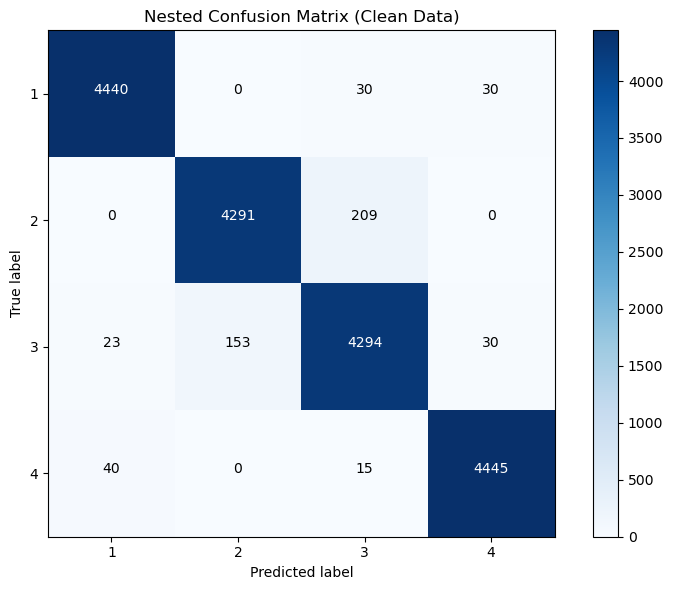


Starting with noisy data

Noisy Data Metrics After Pruning:
Accuracy: 0.8593888888888888
Precision: [0.83551052 0.86546781 0.87235537 0.86589794]
Recall: [0.88516958 0.86059056 0.84943381 0.84106163]
F1 Score: [0.85867444 0.86154793 0.85914696 0.85140368]
Average Depth Before Pruning: 19.288888888888888
Average Depth After Pruning: 14.733333333333333


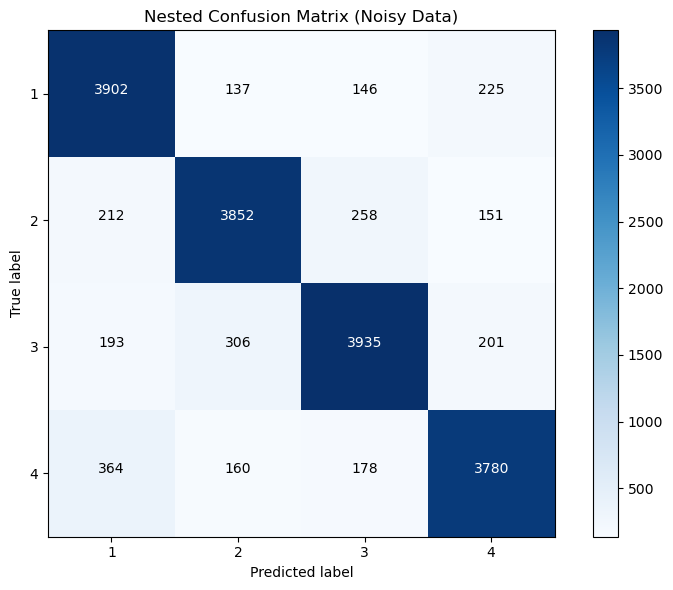

In [110]:
# After pruning, perform nested cross-validation
seed = 42  # You can change the seed for reproducibility

## Clean data
print("Starting with clean data")
pruned_metrics_clean = nested_cross_validation(clean_data, seed=seed)
print("Clean Data Metrics After Pruning:")
print("Accuracy:", pruned_metrics_clean[0])
print("Precision:", pruned_metrics_clean[1])
print("Recall:", pruned_metrics_clean[2])
print("F1 Score:", pruned_metrics_clean[3])
print("Average Depth Before Pruning:", pruned_metrics_clean[5])
print("Average Depth After Pruning:", pruned_metrics_clean[6])
plot_confusion_matrix(pruned_metrics_clean[4], title='Nested Confusion Matrix (Clean Data)')

## Noisy data
print("\nStarting with noisy data")
pruned_metrics_noisy = nested_cross_validation(noisy_data, seed=seed)
print("\nNoisy Data Metrics After Pruning:")
print("Accuracy:", pruned_metrics_noisy[0])
print("Precision:", pruned_metrics_noisy[1])
print("Recall:", pruned_metrics_noisy[2])
print("F1 Score:", pruned_metrics_noisy[3])
print("Average Depth Before Pruning:", pruned_metrics_noisy[5])
print("Average Depth After Pruning:", pruned_metrics_noisy[6])
plot_confusion_matrix(pruned_metrics_noisy[4], title='Nested Confusion Matrix (Noisy Data)')


In [ ]:
## 